Capability Test

In [87]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
from utilities_widgets import widget_selector, widget_int_entry
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
sigma_selector = widget_int_entry(value=6, description="Sigma value (1/2 to each tail) selected")
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')

In [88]:
##Database access
table_list = consult_database("input.db", verbose=False)
default_measurements = consult_database("input.db", verbose=False, filter=glob.tooling+"_measurements_filtered_")[-1]
default_limits = consult_database("input.db", verbose=False, filter=glob.tooling+"_limits_corrected_")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [89]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(5, 3), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_lim…

Table *VA_007_measurements_filtered_2023y_12m_23d_22h_06m_55s* retrieved succesfully.
Table *VA_007_limits_corrected_2023y_12m_23d_22h_04m_11s* retrieved succesfully.


In [90]:
##Working dataframe creation
MEAS_format = rename_index(MEAS); LIMITS_format = rename_index(LIMITS)
DATA = pd.concat([MEAS, LIMITS], axis=1)
DATA.columns = [f"Test: {i}" for i in range(1, DATA.shape[1]-1)] + ["LSL", "USL"]
DATA_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
DATA_format.columns = [f"Test: {i}" for i in range(1, DATA_format.shape[1]-1)] + ["LSL", "USL"]
display(DATA_format)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3226,0.3225,0.3225,0.3225,0.3223,0.3223,0.3223,0.3221,0.3222,0.3222,...,0.3222,0.3221,0.3221,0.3222,0.3222,0.3221,0.3221,0.3222,0.313480,0.338480
Guia_Luz_Blanco_FB1_Y,0.3457,0.3455,0.3455,0.3455,0.3454,0.3454,0.3454,0.3451,0.3452,0.3452,...,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.331756,0.364756
Guia_Luz_Blanco_FB2_X,0.3274,0.3273,0.3272,0.3272,0.3271,0.3272,0.3271,0.3270,0.3270,0.3270,...,0.3268,0.3268,0.3268,0.3267,0.3269,0.3268,0.3268,0.3268,0.313480,0.338480
Guia_Luz_Blanco_FB2_Y,0.3490,0.3490,0.3489,0.3489,0.3489,0.3489,0.3488,0.3487,0.3487,0.3487,...,0.3486,0.3485,0.3485,0.3485,0.3486,0.3485,0.3485,0.3485,0.331756,0.364756
Guia_Luz_Blanco_FB3_X,0.3239,0.3239,0.3238,0.3238,0.3238,0.3238,0.3237,0.3236,0.3235,0.3237,...,0.3236,0.3236,0.3237,0.3237,0.3236,0.3236,0.3236,0.3236,0.313480,0.338480
Guia_Luz_Blanco_FB3_Y,0.3450,0.3450,0.3449,0.3449,0.3449,0.3449,0.3448,0.3447,0.3447,0.3448,...,0.3447,0.3447,0.3448,0.3448,0.3447,0.3447,0.3447,0.3447,0.331756,0.364756
Guia_Luz_Blanco_FB4_X,0.3268,0.3268,0.3267,0.3267,0.3268,0.3266,0.3267,0.3266,0.3266,0.3265,...,0.3265,0.3264,0.3264,0.3264,0.3264,0.3263,0.3264,0.3263,0.313480,0.338480
Guia_Luz_Blanco_FB4_Y,0.3502,0.3501,0.3501,0.3501,0.3501,0.3500,0.3500,0.3500,0.3500,0.3499,...,0.3498,0.3498,0.3498,0.3498,0.3497,0.3497,0.3498,0.3497,0.331756,0.364756
Guia_Luz_Blanco_FB5_X,0.3285,0.3284,0.3284,0.3283,0.3284,0.3283,0.3284,0.3282,0.3282,0.3282,...,0.3281,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.313480,0.338480
Guia_Luz_Blanco_FB5_Y,0.3510,0.3508,0.3508,0.3508,0.3508,0.3508,0.3508,0.3507,0.3507,0.3506,...,0.3505,0.3505,0.3505,0.3504,0.3505,0.3504,0.3505,0.3504,0.331756,0.364756


In [91]:
##Calculation of the specification values
display(means_calculation)
if means_calculation.value == 'Global means':
    specification_means = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    specification_means = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
resume = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns
fiber_values = resume[['mean', 'std']]
fiber_values = fiber_values.rename(columns={'mean': 'fiber mean'})
specification_limits = df.iloc[:, -2:]
specification_limits = specification_limits.rename(columns={49: "LSL", 50: "USL"})
specifications = pd.concat([specification_means, fiber_values, specification_limits], axis=1)
specifications_format = rename_index(specifications)
display(specifications_format)

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean,fiber mean,std,LSL,USL
Guia_Luz_Blanco_FB1_X,0.325980,0.322213,0.000148,0.313480,0.338480
Guia_Luz_Blanco_FB1_Y,0.348256,0.345260,0.000143,0.331756,0.364756
Guia_Luz_Blanco_FB2_X,0.325980,0.326930,0.000180,0.313480,0.338480
Guia_Luz_Blanco_FB2_Y,0.348256,0.348657,0.000159,0.331756,0.364756
Guia_Luz_Blanco_FB3_X,0.325980,0.323640,0.000119,0.313480,0.338480
Guia_Luz_Blanco_FB3_Y,0.348256,0.344757,0.000104,0.331756,0.364756
Guia_Luz_Blanco_FB4_X,0.325980,0.326523,0.000141,0.313480,0.338480
Guia_Luz_Blanco_FB4_Y,0.348256,0.349887,0.000136,0.331756,0.364756
Guia_Luz_Blanco_FB5_X,0.325980,0.328150,0.000153,0.313480,0.338480
Guia_Luz_Blanco_FB5_Y,0.348256,0.350607,0.000148,0.331756,0.364756


In [92]:
##Calculation of the capability values
display(sigma_selector)
analysis = capability_calculation(specifications, sigma_selector.value)
analysis_format = rename_index(analysis)
display(analysis_format)

IntText(value=6, description='Sigma value (1/2 to each tail) selected')

,mean,fiber mean,std,LSL,USL,CAL_LO_LIMIT,CAL_HI_LIMIT,Cp,Cpk
Guia_Luz_Blanco_FB1_X,0.325980,0.322213,0.000148,0.313480,0.338480,0.3218,0.3227,28.165334,19.678180
Guia_Luz_Blanco_FB1_Y,0.348256,0.345260,0.000143,0.331756,0.364756,0.3448,0.3457,38.494691,31.504729
Guia_Luz_Blanco_FB2_X,0.325980,0.326930,0.000180,0.313480,0.338480,0.3264,0.3275,23.106380,21.350295
Guia_Luz_Blanco_FB2_Y,0.348256,0.348657,0.000159,0.331756,0.364756,0.3482,0.3491,34.578989,33.739546
Guia_Luz_Blanco_FB3_X,0.325980,0.323640,0.000119,0.313480,0.338480,0.3233,0.3240,34.957402,28.413376
Guia_Luz_Blanco_FB3_Y,0.348256,0.344757,0.000104,0.331756,0.364756,0.3444,0.3451,52.884391,41.668270
Guia_Luz_Blanco_FB4_X,0.325980,0.326523,0.000141,0.313480,0.338480,0.3261,0.3269,29.624972,28.337273
Guia_Luz_Blanco_FB4_Y,0.348256,0.349887,0.000136,0.331756,0.364756,0.3495,0.3503,40.506072,36.503200
Guia_Luz_Blanco_FB5_X,0.325980,0.328150,0.000153,0.313480,0.338480,0.3277,0.3286,27.310891,22.569720
Guia_Luz_Blanco_FB5_Y,0.348256,0.350607,0.000148,0.331756,0.364756,0.3502,0.3511,37.061634,31.781911


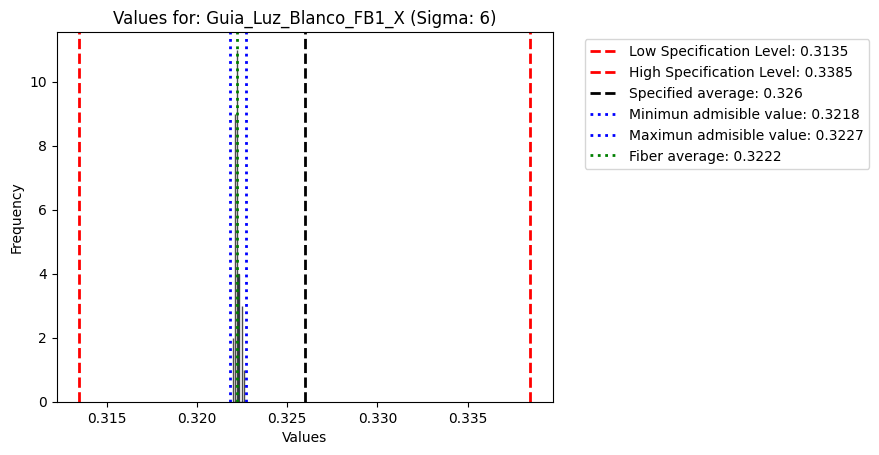

In [93]:
##Visualization of the capability values
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider.value)]
    xrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_capability(MEAS_format, analysis_format, label, sigma_selector.value, xrange=xrange)

In [94]:
##Data export
name = glob.tooling + "_capability_report_" + get_date() + ".xlsx"
confirmation = input("Do you want to export the data to a new Target.xlsx file and generate a new limits ini file? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name)
    analysis_format.to_excel(output_filepath, index=True, header=True)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Data exported inside: {output_filepath}')
else:
    print("Operation canceled.")

Operation canceled.
